In [1]:
!pip install --upgrade pandas-datareader

In [2]:
!pip install pandas-datareader yfinance matplotlib scikit-learn numpy tensorflow

ERROR: Could not find a version that satisfies the requirement tensorflow (from versions: none)
ERROR: No matching distribution found for tensorflow


# Reading data

Pandas datareader provides a function get_data_yahoo to directly fetch the stock data of the specified stock from Yahoo Finance for the given duration. WE are extracting the Apple stock price between the duration from 1970-01-01 to 2022-04-25.

In [3]:
import pandas_datareader.data as pdr
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
from tensorflow import keras
yf.pdr_override()
from datetime import datetime

In [4]:
df_apple = pdr.get_data_yahoo('CSGN.SW', datetime(1970, 1, 1))
df_apple

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1995-04-14,22.104790,22.104790,22.104790,22.104790,8.429320,0
1995-04-17,22.104790,22.104790,22.104790,22.104790,8.429320,0
1995-05-01,21.325602,21.325602,21.325602,21.325602,8.132188,0
1995-05-16,23.596239,23.596239,23.596239,23.596239,8.998061,0
1995-05-23,23.373589,23.373589,23.373589,23.373589,8.913158,0
...,...,...,...,...,...,...
2023-03-27,0.778000,0.786800,0.756600,0.763200,0.763200,24442377
2023-03-28,0.775000,0.789600,0.764200,0.768800,0.768800,28922439
2023-03-29,0.780000,0.809000,0.773600,0.799800,0.799800,52664667


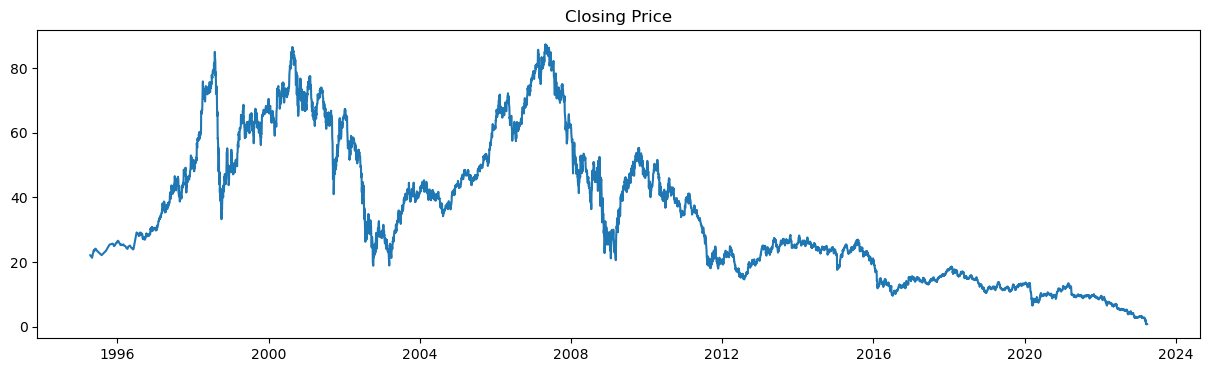

In [5]:
df = df_apple['Close']
plt.figure(figsize = (15,4))
plt.plot(df)
plt.title("Closing Price")
plt.show()

# Dividing the dataset
Since this is time-series data, we cannot use the scikit-learn train_test_split() function because we need to preserve the order of prices. So, we will use, starting 80% of the values as a training dataset and the rest for testing. We also reshaped the datasets to make them compatible for the next step which is normalization. 

In [6]:
last_index = int(len(df) * 0.8)
train_complete = df[:last_index]

last_index_train = int(len(train_complete) * 0.8)
train = train_complete[:last_index_train].values.reshape(-1, 1)
validation = train_complete[last_index_train:].values.reshape(-1, 1)

test = df[last_index:].values.reshape(-1,1)

train.shape, validation.shape, test.shape

((4382, 1), (1096, 1), (1370, 1))

# Normalization
Normalization converts all the values in the range of 0 to 1. It improves convergence and hence reduces training time.

In [7]:
from sklearn.preprocessing import MinMaxScaler
 
scaler = MinMaxScaler()
train = scaler.fit_transform(train)
validation = scaler.fit_transform(validation)
test = scaler.transform(test)

train[:10]

array([[0.10240309],
       [0.10240309],
       [0.09168932],
       [0.12291038],
       [0.11984895],
       [0.12750127],
       [0.13056269],
       [0.12291038],
       [0.10301486],
       [0.1206143 ]])

# Splitting the dataset into X and Y
This function specifies how many previous values must be considered to find out the pattern, in order to predict a price. Accordingly, both, the training and testing datasets are split into X and Y.

In [8]:
def create_dataset(dataset, time_step=1):
  data_X, data_Y = [], []
  for i in range(len(dataset)-time_step-1):
    a = dataset[i:(i + time_step), 0]   
    data_X.append(a)
    data_Y.append(dataset[i + time_step, 0])
  return np.array(data_X), np.array(data_Y)

time_step = 100

X_train, y_train = create_dataset(train, time_step)
X_validation, y_validation = create_dataset(validation, time_step)

X_test, y_test = create_dataset(test, time_step)

In [9]:
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1], 1)
X_validation = X_validation.reshape(X_validation.shape[0], X_validation.shape[1], 1)

X_test = X_test.reshape(X_test.shape[0],X_test.shape[1], 1)

In [10]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, GRU

model = Sequential([
    GRU(1024, input_shape=[100, 1,]),
    Dense(1)
])
model.compile(loss = 'mean_squared_error', optimizer = 'adam')
model.build()
model.summary()

Metal device set to: Apple M1 Pro

systemMemory: 32.00 GB
maxCacheSize: 10.67 GB



2023-03-31 13:16:28.245663: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-03-31 13:16:28.245772: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 1024)              3154944   
                                                                 
 dense (Dense)               (None, 1)                 1025      
                                                                 
Total params: 3,155,969
Trainable params: 3,155,969
Non-trainable params: 0
_________________________________________________________________


In [11]:
history = model.fit(X_train, y_train, validation_data = (X_validation, y_validation), epochs = 25)

Epoch 1/25


2023-03-31 13:16:28.840457: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-03-31 13:16:29.321225: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-03-31 13:16:29.467924: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-03-31 13:16:29.928194: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


134/134 [==============================] - ETA: 0s - loss: 0.0042

2023-03-31 13:16:46.268099: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-03-31 13:16:46.318539: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


134/134 [==============================] - 19s 129ms/step - loss: 0.0042 - val_loss: 6.7106e-04
Epoch 2/25
134/134 [==============================] - 16s 119ms/step - loss: 4.4102e-04 - val_loss: 7.8945e-04
Epoch 3/25
134/134 [==============================] - 16s 119ms/step - loss: 4.2011e-04 - val_loss: 6.7601e-04
Epoch 4/25
134/134 [==============================] - 16s 117ms/step - loss: 4.1360e-04 - val_loss: 6.2252e-04
Epoch 5/25
134/134 [==============================] - 16s 117ms/step - loss: 4.0073e-04 - val_loss: 6.2745e-04
Epoch 6/25
134/134 [==============================] - 16s 117ms/step - loss: 3.8309e-04 - val_loss: 6.1325e-04
Epoch 7/25
134/134 [==============================] - 16s 118ms/step - loss: 3.8387e-04 - val_loss: 5.9855e-04
Epoch 8/25
134/134 [==============================] - 16s 118ms/step - loss: 4.0154e-04 - val_loss: 5.0856e-04
Epoch 9/25
134/134 [==============================] - 16s 118ms/step - loss: 3.5290e-04 - val_loss: 6.2140e-04
Epoch 10/25
134/

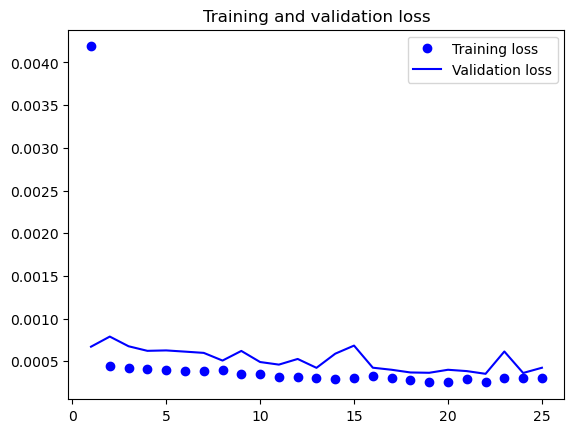

In [12]:
def plot_history(history):
    #acc = history.history['acc']
    #val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    epochs = range(1, len(loss) + 1)
    
    #plt.plot(epochs, acc, 'bo', label='Training acc')
    #plt.plot(epochs, val_acc, 'b', label='Validation acc')
    #plt.title('Training and validation accuracy')
    #plt.legend()
    
    plt.figure()
    
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()
plot_history(history)

In [13]:
test_predict = model.predict(X_test)
print(test_predict.shape)
test_predict[:10]

2023-03-31 13:23:06.423522: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-03-31 13:23:06.467466: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


40/40 [==============================] - 2s 27ms/step
(1269, 1)


array([[0.39975804],
       [0.4077644 ],
       [0.3912988 ],
       [0.40279427],
       [0.3728968 ],
       [0.34817448],
       [0.33768645],
       [0.32134745],
       [0.3330496 ],
       [0.33227965]], dtype=float32)

# Inversing Transformation
Since we normalized the data earlier and converted all the values in the range 0 to 1, now we should inverse the transformation to get actual values. 

In [14]:
test_predict=scaler.inverse_transform(test_predict)

# Visualizing the predictions
Here we have plotted actual and predicted stock prices for the test dataset. We can see that the model is performing fine.

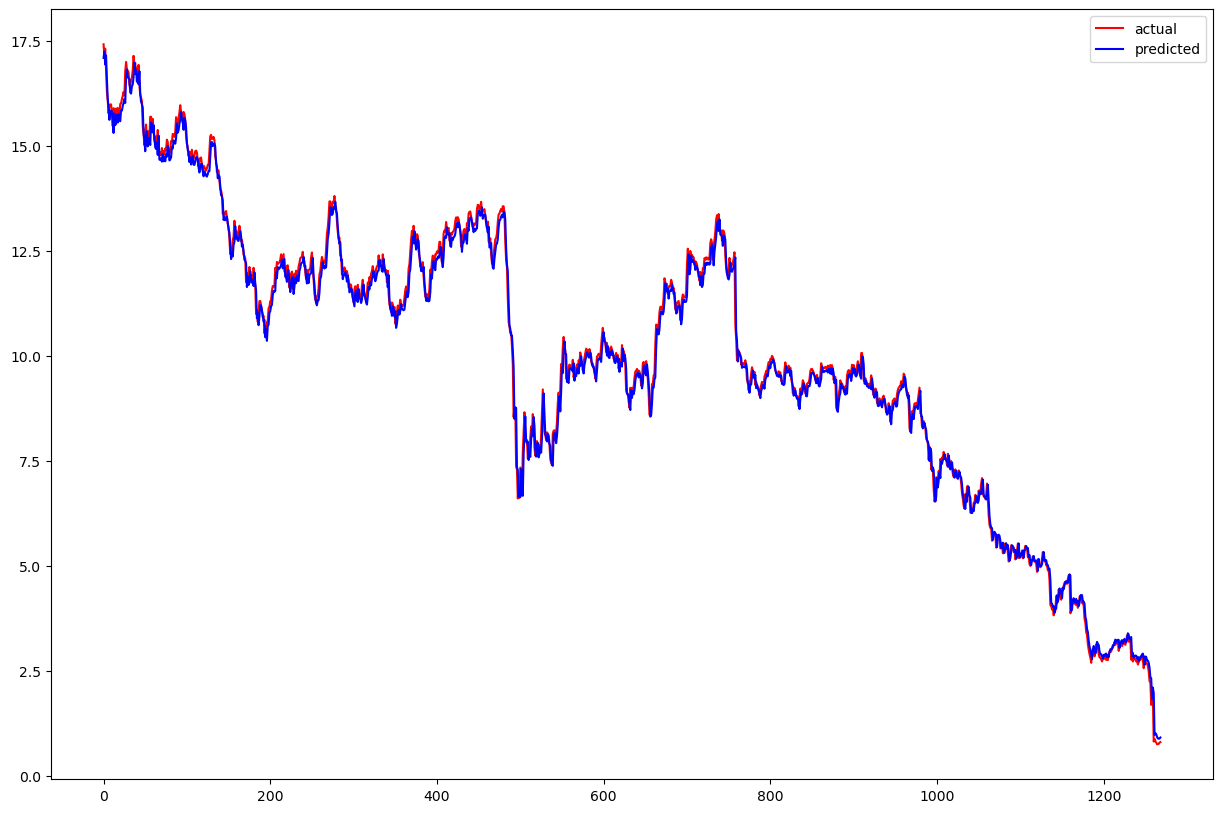

In [15]:
plt.figure(figsize = (15,10))
plt.plot(scaler.inverse_transform(y_test.reshape(-1,1)), color = 'r', label = 'actual')
plt.plot(test_predict, color = 'b',label = 'predicted')
plt.legend()
plt.show()

# Evaluating model
For evaluation, we will be using root mean square values.

In [16]:
from sklearn.metrics import mean_squared_error
mean_squared_error(y_test,test_predict, squared = False)

10.434893677781073